# 🐧 The Evolution of Puffin's Population Regarding Climate Change

Welcome to the main Jupyter Notebook of our _Python project for Data Science_ ! 
Studying at the engineering school ENSAE, Institut Polytechnique de Paris, this project is part of the 2nd year course, under the supervision of Lino Galiana (Insee) and Romain Avouac (Insee). 

We share a passion for a clumsy but reaaaally cute seabird that is very common in Iceland : **the Atlantic puffin**. Unluckily, its demographic trend is downward. Well, it's not all by chance. Various high-qualited scientific studies have been carried out over the years to demonstrate the challenges facing this seabird species. Its biggest enemy to date is **climate change**, which is affecting its feeding (fish), reproduction and nesting. 

With this notebook, we set out to (re)demonstrate the causal link between global warming and the decline in the Atlantic puffin population. **The aim at the end of this page is to establish medium-term predictions for the evolution of this species, taking into account the different climate scenarios envisaged. Graphical visualization tools will support our modeling results.** 

Are you ready to see the disastrous consequences of climate change on such adorable birds? Let's get started! 
🐧🐧🐧🐧🐧🐧

## 💻 0. Setting up the work environment 

- data access through the cloud MinIO Client (files are in the folder 'diffusion')
- required packages 
- organizated environment 

In [ ]:
!pip install -r requirements.txt # run this cell to install all the packages needed 

In [8]:
#import of libraries 

import os
import webbrowser
import s3fs
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import plotly.graph_objects as go
import calendar

import contextily as ctx
import folium
from folium import LayerControl
import geopandas as gpd

from shapely.geometry import Polygon, LineString, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
from IPython.display import display

In [3]:
# Creation of two folders to centralize data and results
data_dir = "./data"  
os.makedirs(data_dir, exist_ok=True) 
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)


# Access information to the cloud MinIO Client (Eve's bucket)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "esam"


## 🔗 1. Installing databases

As mentioned in the README, our data comes from : 
- **APIs** for climate data from Copernicus 
- **download free data** from scientific articles on the Internet 
- **free requests** to BirdLife International for access to puffin geographical data, sent by e-mail or via our account (with identification and verification procedure) on their platform. 

In order to provide **easy and secure access to this data for anyone wishing to run our code**, we have made it available on a _MinIO Client cloud_. 
You can access the entire bucket construction process on this Notebook : [Go to get_data Notebook](get_data.ipynb)

Otherwise, we'll be calling our data from our cloud (using s3fs) all through this notebook script. 

## ☞ What's next ? 

The rest of the project is divided into several stages: 
- data visualization and understanding
- modeling

During the visualization phase, we'll be observing the distribution of puffins in space, as well as changes in sea surface temperature (which will be the main explanatory variable). 
Then, we'll try to take the puffin reproduction rate as a demographic proxy for the species (based on the methodology of the article by ...) in order to predict the evolution of the species as a function of climate change through different estimation and prediction models. 

# Part 1 : Visualization 

## 🗺️ 1. Map visualization of Atlantic puffin distribution worldwide 

The Atlantic puffin is a migratory bird of the North Atlantic and Arctic polar zones. BirdLife International's data enable us to visualize the presence of these birds across the globe. 

### 1.1 MinIO Client cloud data retrieval and overview

_Nota bene : Having encountered difficulties working with files directly in S3 streams (shapefile, .nc, etc.), it is preferable to download files directly from the MinIO Client locally, to ensure optimal operation of the pandas and geopandas ecosystems, which is what the following program does._ 

In [17]:
# Creation of a subfolder to store Shapefile files and downloading of needed files
local_shapefile_subfolder = os.path.join(data_dir, "local_shapefile_files")
os.makedirs(local_shapefile_subfolder, exist_ok=True)

shapefile_elements = ["F_arctica.shp", "F_arctica.shx", "F_arctica.dbf"]
for element in shapefile_elements:
    remote_path = f"{MY_BUCKET}/diffusion/puffin_data/{element}"
    local_path = os.path.join(local_shapefile_subfolder, element)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())

# Lecture of the main shapefile file
local_shapefile_path = os.path.join(local_shapefile_subfolder, "F_arctica.shp")
gdf = gpd.read_file(local_shapefile_path)

### 2.2 Preparing files for graphical display

Geographic data and geometries must be correctly parameterized to be correctly displayed on a map.
The 'Coordinate Reference System' (CRS) EPSG:4326 displays geographic coordinates based on longitude and latitude. Its main uses are : 
- satellite data 
- global cartography 
- geographic data reference system

In [18]:
# Correction of the CRS to obtain the correct lecture of geographic coordinates
if gdf.crs != "EPSG:4326":
    print("The initial CRS is :", gdf.crs)
    gdf = gdf.set_crs(epsg=4326)
    print("The CRS has been redefined as EPSG:4326.")

# Simplification of the geometries
#if len(gdf) > 1000:  # Par exemple, pour les fichiers volumineux
gdf["geometry"] = gdf["geometry"].simplify(tolerance=0.01)
print("Geometries have been simplified.")

# Conversion to 2D geometries
def convert_to_2d(geom):
    if geom is not None and geom.has_z:
        return geom.simplify(0)  # Suppression de la dimension Z
    return geom

gdf["geometry"] = gdf["geometry"].apply(convert_to_2d)

# Checking of validated geometries
invalid_count = (~gdf.is_valid).sum()
print(f"Number of invalided geometries before correction : {invalid_count}")

# Correction of invalided geometries
if invalid_count > 0:
    gdf["geometry"] = gdf["geometry"].buffer(0)

The initial CRS is : None
The CRS has been redefined as EPSG:4326.
Geometries have been simplified.
Number of invalided geometries before correction : 2


### 2.3 Creation of a reactive folium map to visualize the worldwide presence of Atlantic puffins.

The Atlantic puffin lives on the high seas all year round, but returns to land when it breeds. This map shows the areas of non-breeding and breeding of the species, using reference data from BirdLife International.

The detailed puffin observation databases we use are established in breeding areas. 

In [56]:
# Add a "seasonal_label" column to the GeoDataFrame before creating the layers
gdf['seasonal_label'] = gdf['seasonal'].replace({
    2: "Breeding area",
    3: "Non-breeding area"
})

# Select the zones
breeding_zones = gdf[gdf["seasonal"] == 2]
non_breeding_zones = gdf[gdf["seasonal"] == 3]

# Create the Folium map
m = folium.Map(location=[55, 0], zoom_start=3, tiles="CartoDB Positron")

# Function to create a GeoJSON layer
def create_folium_layer(gdf, name, color):
    return folium.GeoJson(
        gdf,
        name=name,
        tooltip=folium.GeoJsonTooltip(
            fields=["sci_name", "presence", "seasonal_label"],  # Use "seasonal_label"
            aliases=["Scientific name", "Presence", "Seasonal"], 
            localize=True,
        ),
        style_function=lambda feature: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
        },
    )

# Create the layers
breeding_layer = create_folium_layer(breeding_zones, "Breeding zones", "green")
non_breeding_layer = create_folium_layer(non_breeding_zones, "Non-breeding zones", "lime")

# Add the layers to the map
breeding_layer.add_to(m)
non_breeding_layer.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

### 2.4 Display of the folium map

Two options are possible : 
- display the folium map in the Notebook 
    * concentrates all results in this single notebook 
    * considerably heavier
- generate a HTML link for the folder ./results and generate a local server from the terminal to open a web page 

In [ ]:
# 1st option : Displaying the map in the notebook 
display(m)

In [57]:
# 2nd option : HTML Link 

m.save("./results/puffin_distribution_map.html")
print(f"{os.path.abspath('./results')}")

""" Then, copy cell output and enter in the bash : 
cd <absolute path you just copy> 
python -m http.server 8000

A new web page should open. All you have to do is select the "puffin_distribution_map" ! 

If you accidentally close the web page, you can reopen it by typing in your terminal : 
python -m http.server 8000
"""

/home/onyxia/work/projet_python_2024_ENSAE/results


' Then, copy cell output and enter in the bash : \ncd <absolute path you just copy> \npython -m http.server 8000\n\nA new web page should open. All you have to do is select the "puffin_distribution_map" ! \n\nIf you accidentally close the web page, you can reopen it by typing in your terminal : \npython -m http.server 8000\n'

### 🧑‍💻 About local server... 
A **local server** is a web server environment that runs solely on your computer. It uses your machine as a “server” to deliver files, HTML content or web applications to a browser via a local URL (such as http://localhost:8000).
- localhost: A special address that refers to your own machine. 
- Port: A number used to distinguish different services on your machine. By default, a local server often uses port 8000 or 8080.

_Step 1: Launch a local server_
- Open a terminal and navigate to the directory containing your files.
- Run the following command:
    _python -m http.server 8000_

_Step 2: Access the server in a browser_
- Open a browser.
- Go to http://localhost:8000.
You'll see the files in the directory as if you were browsing a website.

Other informations:
- Limited access: here, the local server is only accessible from your own machine.
- Stop server: to stop it, press Ctrl+C in the terminal.
- Applications : web development (test sites or applications locally before deploying them online), data visualization (serve files such as Folium maps or interactive graphic). 

## 🌊🥵 2. What about climate change ? 

Let's have a look to our climate data from Copernicus. These will be used as an explanatory variable to study the evolution of puffins. 



### 2.1 Selection and visualization of the study area (Vestmann Islands, Iceland)

We selected a specific area where data on the puffin population is available. This area is located in the Vestmannaeyjar (Vestmann Islands), an archipelago situated south of Iceland, home to 2 to 4 billion puffins.

If you would like to visualize the Vestmann Islands, run the next cell.

In [ ]:
# Load a high-resolution shapefile for Iceland
# Use a freely available shapefile for country boundaries
url = "https://github.com/datasets/geo-countries/raw/main/data/countries.geojson"
world = gpd.read_file(url)

# Filter for Iceland
iceland = world[world['ADMIN'] == 'Iceland']

# Define the coordinates of the Vestmann Islands
vestmann_islands_coords = [
    (63.441, -20.273),  # Heimaey
    (63.426, -20.285),  # Elliðaey
    (63.396, -20.225),  # Bjarnarey
]

# Convert the Vestmann Islands' coordinates into a GeoDataFrame
vestmann_gdf = gpd.GeoDataFrame(
    {
        'Name': ['Heimaey', 'Elliðaey', 'Bjarnarey'],
        'Coordinates': vestmann_islands_coords,
    },
    geometry=gpd.points_from_xy(
        [coord[1] for coord in vestmann_islands_coords],  # Longitude
        [coord[0] for coord in vestmann_islands_coords],  # Latitude
    ),
    crs="EPSG:4326",  # Set the coordinate reference system to WGS 84
)

# Create a better map with contextily basemap
fig, ax = plt.subplots(figsize=(12, 12))
# Plot Iceland's boundaries
iceland = iceland.to_crs(epsg=3857)  # Reproject to Web Mercator for basemap compatibility
iceland.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=1)

# Plot the Vestmann Islands
vestmann_gdf = vestmann_gdf.to_crs(epsg=3857)  # Reproject to match Iceland's CRS
vestmann_gdf.plot(ax=ax, color="red", markersize=100, label="Vestmann Islands")

# Add a basemap from contextily (OpenStreetMap tiles)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=8)

# Customize the map
plt.title("Map of Iceland with Vestmann Islands", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()

# Show the map
plt.show()

We can also create another folium map to have more reactive visualization tools. 
By running the cell above, you can create a new layer which indicate Vestmann Islands. The map is automatically added to your local server once it is available. 

In [58]:
# Define the coordinates of the Vestmann Islands
vestmann_islands_coords = [
    (63.441, -20.273),  # Heimaey
    (63.426, -20.285),  # Elliðaey
    (63.396, -20.225),  # Bjarnarey
]

# Create a new map or use the existing one
m = folium.Map(location=[63.4, -20.25], zoom_start=10, tiles="OpenStreetMap")

# Recreate the previous layers
breeding_layer = create_folium_layer(breeding_zones, "Breeding zones", "green")
non_breeding_layer = create_folium_layer(non_breeding_zones, "Non-breeding zones", "lime")

# Add the previous layers to the map
breeding_layer.add_to(m)
non_breeding_layer.add_to(m)

# Create a FeatureGroup for the Vestmann Islands layer
vestmann_layer = folium.FeatureGroup(name="Vestmann Islands Zone")

# Add markers for each coordinate to the FeatureGroup
for lat, lon in vestmann_islands_coords:
    folium.Marker(
        location=[lat, lon],
        popup=f"Marker at ({lat}, {lon})",
        icon=folium.Icon(color="red", icon="none"),
    ).add_to(vestmann_layer)

# Add the FeatureGroup to the map
vestmann_layer.add_to(m)

# Add LayerControl to the map
folium.LayerControl().add_to(m)

# Save the map for debugging
output_path = "./results/map_with_vestmann_layer.html"
m.save(output_path)

print(f"Map saved to {output_path}")

Map saved to ./results/map_with_vestmann_layer.html


### 2.2. MinIO Client cloud data retrieval and overview

_Nota bene : Having encountered difficulties working with files directly in S3 streams (shapefile, .nc, etc.), it is preferable to download files directly from the MinIO Client locally, to ensure optimal operation of the pandas and geopandas ecosystems, which is what the following program does._ 

Let's retrieve the Copernicus data. 
If you want to see how this data was obtained, please refer to the [get_data.ipynb](get_data.ipynb) file.

In [4]:
# Creation of a subfolder to store .nc files and to download every files of the folder cds_data of the cloud 
local_cds_subfolder = os.path.join(data_dir, "local_cds_files")
os.makedirs(local_cds_subfolder, exist_ok=True)

# Extraction of files' name
cds_elements = fs.ls(f"{MY_BUCKET}/diffusion/cds_data")
cds_file_names = [os.path.basename(file) for file in cds_elements]


for file_name in cds_file_names:
    print(file_name)
    remote_path = f"{MY_BUCKET}/diffusion/cds_data/{file_name}"
    local_path = os.path.join(local_cds_subfolder, file_name)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())


tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc
tos_Omon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20491216.nc
tos_Omon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20491216.nc
tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc


Converting NetCDF4 files into Pandas DataFrame is not an easy task. We encounter several difficulties by using xarray and another way to safely convert these files is to use netCDF4 package. 

🤯 In-depth study of our files led us to discover a number of _tricky issues_: 
- **latitude and longitude** have been written as (x, x) and not as a scalar: we therefore use the float() command to transform them in order to incorporate them into a readable data frame. 
- **time** data were not defined on a Gregorian calendar (360_day). Tools like Pandas or NumPy assume a standard Gregorian calendar (with 365 or 366 days per year).The 360_day calendar is not directly compatible with these tools and we need cftime, a library that supports different calendars (such as 360_day, julian, gregorian, etc.) to convert time.

🔍 First, let’s visualize the historical data from Copernicus. It represents the ocean surface temperature in the Vestmann Islands area from 1950 to 2014.

In [16]:
import netCDF4 as nc
from netCDF4 import Dataset

# Downloading of the NetCDF file
file_path = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
dataset = nc.Dataset(file_path, mode="r")

# This step may seem unnecessary, but it helped us understand the somewhat specific format of our variables.
print(dataset.variables["tos"]) # Expressed in degrees celcius 
print(dataset.variables["latitude"])
print(dataset.variables["time"])


# Variable format conversion for a dataframe 
# Extraction of latitude and longitude as scalars 
times = dataset.variables["time"][:]  # Temps
time_unit = dataset.variables["time"].units  # Unité de temps
time_calendar = dataset.variables["time"].calendar  # Calendrier
tos = dataset.variables["tos"][:]  # Température de surface
lats = float(dataset.variables["latitude"][:])
lons = float(dataset.variables["longitude"][:])

# Conversion of times with cftime
time_indices = cftime.num2date(times, units=time_unit, calendar=time_calendar)

# time format standardization (Pandas datetime)
time_indices = pd.to_datetime([t.strftime('%Y-%m-%d') for t in time_indices])

# Creation of a DataFrame with geographic coordinates
tos_df = pd.DataFrame({
    "Time": time_indices,  # Converted times
    "Latitude": [lats] * len(times),  # This ensures that each time has an associated latitude, even if it is fixed for all lines.
    "Longitude": [lons] * len(times),  # Same 
    "TOS": tos[:, 0, 0] # TOS values 
})

# Displaying an overview 
print("Aperçu des données TOS :")
print(tos_df.head(30))


# Creation of a new subfolder to save this data in csv format for easier use in the rest of the code 
os.makedirs("data/cds_data_treated", exist_ok=True)  

# Saving of this dataframe into the new subfolder
output_path = os.path.join(output_dir, "tos_historical_data.csv")
tos_df.to_csv(output_path, index=False)
   


<class 'netCDF4.Variable'>
float32 tos(time, j, i)
    standard_name: sea_surface_temperature
    long_name: Sea Surface Temperature
    comment: Temperature of upper boundary of the liquid ocean, including temperatures below sea-ice and floating ice shelves.
    units: degC
    original_name: mo: (variable_name: tos)
    cell_methods: area: mean where sea time: mean
    cell_measures: area: areacello
unlimited dimensions: time
current shape = (780, 1, 1)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4.Variable'>
float32 latitude(j, i)
    _FillValue: 1e+20
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    bounds: vertices_latitude
    missing_value: 1e+20
unlimited dimensions: 
current shape = (1, 1)
filling on
<class 'netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    axis: T
    long_name: time
    standard_name: time
    units: days since 1850-01-01
    calendar: 360_day
unlimited dimensions: time
current shap

### 2.3. Visualization of the evolution of the sea surface temperature of historical Copernicus data 

To improve the readability of this data, we can use plotly to create a slightly more interactive graph and look at the evolution of our variable tos (sea surface temperature) for each month, from 1950 to 2014. 🌡️

In [13]:
# Adding of a column "month" in our previous dataframe tos_df 
tos_df["Month"] = tos_df["Time"].dt.month
tos_df["Month_Name"] = tos_df["Month"].apply(lambda x: calendar.month_name[x])  # Months names

# Initialization of the figure
fig = go.Figure()

# Pastel shades (so as not to irritate the eyes, small details count :D)
colors = [
    "mistyrose", "#FFE5B4", "lemonchiffon", "thistle", "aliceblue",
    "#F5F5F5", "#FAF0E6", "mintcream", "#FFB3BA", "#B3E5FC", "#FFECB3", "#C8E6C9"
]

# A curve per month
for month, color in zip(range(1, 13), colors):
    month_name = calendar.month_name[month]
    month_data = tos_df[tos_df["Month"] == month]
    fig.add_trace(go.Scatter(
        x=month_data["Time"],
        y=month_data["TOS"],
        mode="lines",
        name=month_name,  # Month in the legend
        line=dict(color=color, width=2),
        hoverinfo="x+y+name"
    ))


fig.update_layout(
    title="Monthly Sea Surface Temperature (TOS) Over Time",
    xaxis_title="Time",
    yaxis_title="TOS (°C)",
    template="plotly_white",
    legend_title="Months",
    hovermode="x unified",
    width=1000,  
    height=500,  
)

# Display graph
fig.show()

output_path = os.path.join(results_dir, "tos_graphic_historical.html")
fig.write_html(output_path)


Visualization according to the month of the year gives us a better understanding of changes in sea surface temperature. We can easily detect an increasing of the temperatures, for the past 30 years, in any given month. 

### 2.4. Visualization and comparison of the sea surface temperature in the future, for various scenarios

The scope of the Copernicus CMIP6 project gives us access to forecasts of our TOS variable according to several climate scenarios (pessimistic - intermediate - optimistic). 

We are going to try to observe the evolution of temperature according to these different climate scenarios, with the data we've previously downloaded via API and stored in our cloud.

In [21]:
# Dictionnaire des fichiers et leurs scénarios correspondants
file_scenarios = {
    "ssp126": "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20491216.nc",
    "ssp245": "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20491216.nc",
    "ssp585": "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc"
}

# Dictionnaire pour stocker les DataFrames
scenario_dataframes = {}

# Itérer sur chaque fichier et scénario
for scenario, file_path in file_scenarios.items():
    # Charger le fichier NetCDF
    dataset = nc.Dataset(file_path, mode="r")
    
    # Extraire les variables nécessaires
    times = dataset.variables["time"][:]  # Temps
    time_unit = dataset.variables["time"].units  # Unité de temps
    time_calendar = dataset.variables["time"].calendar  # Calendrier
    tos = dataset.variables["tos"][:]  # Température de surface
    lats = float(dataset.variables["latitude"][:])
    lons = float(dataset.variables["longitude"][:])
    
    # Conversion des temps avec cftime
    time_indices = cftime.num2date(times, units=time_unit, calendar=time_calendar)
    
    # Standardisation des dates au format Pandas
    time_indices = pd.to_datetime([t.strftime('%Y-%m-%d') for t in time_indices])
    
    # Création d'un DataFrame pour ce scénario
    tos_df = pd.DataFrame({
        "Time": time_indices,  # Dates converties
        "Latitude": [lats] * len(times),  # Répéter la latitude
        "Longitude": [lons] * len(times),  # Répéter la longitude
        "TOS": tos[:, 0, 0]  # Valeurs TOS
    })
    
    # Ajouter au dictionnaire avec le nom du scénario
    scenario_dataframes[scenario] = tos_df

    output_path = os.path.join("./data/cds_data_treated", f"tos_{scenario}_data.csv")
    tos_df.to_csv(output_path, index=False)
    print(f"Data for {scenario} successfully saved to {output_path}")

# Assigner chaque DataFrame à une variable globale (facultatif)
tos_ssp126_df = scenario_dataframes.get("ssp126")
tos_ssp245_df = scenario_dataframes.get("ssp245")
tos_ssp585_df = scenario_dataframes.get("ssp585")

Data for ssp126 successfully saved to ./data/cds_data_treated/tos_ssp126_data.csv
Data for ssp245 successfully saved to ./data/cds_data_treated/tos_ssp245_data.csv
Data for ssp585 successfully saved to ./data/cds_data_treated/tos_ssp585_data.csv


In [23]:
import plotly.graph_objects as go
import os
import pandas as pd
import calendar

# Dictionnaire pour attribuer une gamme de couleurs à chaque scénario
scenario_colors = {
    "ssp126": ["#FFC0CB", "#FF69B4", "#FF1493"],  # Gamme de rose
    "ssp245": ["#ADD8E6", "#6495ED", "#0000FF"],  # Gamme de bleu
    "ssp585": ["#90EE90", "#32CD32", "#008000"]   # Gamme de vert
}

# Dictionnaire pour stocker les DataFrames de scénarios
scenario_dataframes = {
    "ssp126": tos_ssp126_df,  # Assurez-vous que ces DataFrames sont chargés
    "ssp245": tos_ssp245_df,
    "ssp585": tos_ssp585_df
}

# Ajouter une colonne pour les groupes de 4 mois
for scenario, df in scenario_dataframes.items():
    df["Month"] = df["Time"].dt.month  # Extraire le mois
    df["Year"] = df["Time"].dt.year    # Extraire l'année
    df["Group"] = pd.cut(
        df["Month"],
        bins=[0, 4, 8, 12],
        labels=["Jan-Apr", "May-Aug", "Sep-Dec"],
        include_lowest=True
    )

# Initialisation de la figure
fig = go.Figure()

# Tracer une courbe pour chaque groupe de mois et chaque scénario
for scenario, df in scenario_dataframes.items():
    for group, color in zip(["Jan-Apr", "May-Aug", "Sep-Dec"], scenario_colors[scenario]):
        group_data = df[df["Group"] == group]
        
        # Calculer la moyenne des TOS par année pour le groupe donné
        avg_data = group_data.groupby("Year")["TOS"].mean().reset_index()
        
        # Ajout de la courbe
        fig.add_trace(go.Scatter(
            x=avg_data["Year"],
            y=avg_data["TOS"],
            mode="lines",
            name=f"{scenario} ({group})",  # Légende
            line=dict(color=color, width=2),
            hoverinfo="x+y+name"
        ))

# Mise en page du graphique
fig.update_layout(
    title="Comparaison des moyennes trimestrielles de TOS par scénario",
    xaxis_title="Année",
    yaxis_title="TOS (°C)",
    template="plotly_white",
    legend_title="Scénarios et périodes",
    hovermode="x unified",
    width=1000,  
    height=600  
)

# Afficher le graphique
fig.show()

# Sauvegarder au format HTML
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)
output_path = os.path.join(results_dir, "tos_comparison_scenarios.html")
fig.write_html(output_path)
print(f"Graph saved to {output_path}")


Graph saved to results/tos_comparison_scenarios.html


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

######################### VISUALIZE DIFFERENT SCENARIOS #############################

# Paths to the NetCDF files
file_paths = [
    "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_20150116-20491216.nc",  # Scenario 1
    "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_20150116-20491216.nc",  # Scenario 2
    "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc"   # Scenario 3
]

# Names of the scenarios for the subplot titles
scenario_names = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]

# Colors for each scenario
colors = ["blue", "green", "red"]

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

# Loop through the files and create a subplot for each scenario
for i, (file_path, ax) in enumerate(zip(file_paths, axes)):
    # Load the NetCDF file
    data = xr.open_dataset(file_path)
    
    # Extract the sea surface temperature (tos) data
    tos = data['tos']
    
    # Select a specific grid point (e.g., i=0, j=0)
    tos_at_point = tos.sel(i=0, j=0, method='nearest')
    
    # Plot the data in the current subplot
    ax.plot(
        tos_at_point['time'],  # X-axis: time
        tos_at_point,          # Y-axis: sea surface temperature
        label=scenario_names[i], # Legend based on the scenario
        color=colors[i]           # Unique color for each scenario
    )
    
    # Customize the current subplot
    ax.set_title(f"Sea Surface Temperature - {scenario_names[i]}")
    ax.set_ylabel("SST (°C)")
    ax.grid(True)
    ax.legend(loc='upper left')
    
    # Close the NetCDF file to release resources
    data.close()

# Customize the x-axis for the last subplot
axes[-1].set_xlabel("Time")
axes[-1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

## 🐧 Let's find our puffin population

The study "Centennial relationships between ocean temperature and Atlantic puffin production reveal shifting decennial trends" focuses on the Atlantic puffin population in southwest Iceland. It shows that chick production is strongly influenced by sea surface temperature (SST), with non-linear, non-stationary correlations. The study reveals peak productivity at 7.1°C and a decline in puffin populations linked to rising SST throughout the 20th century.

The data from this study are publicly available and are being used in this project. The scientists created a variable to represent chick production, which we use as a proxy to evaluate the puffin population in the Vestmann Islands. In the following paragraph, we will briefly explain how this variable is generated.

### A few word about the article and the data

### Chick Production in Seabirds and Its Estimation

Chick production refers to the number of chicks that are successfully fledged (raised to independence) by a given seabird population in a specific year. This metric is vital for understanding how environmental changes, such as global warming, affect population dynamics in seabirds like the Atlantic puffin (*Fratercula arctica*). Factors such as climate variability, food availability, and the survival rates of adult birds all influence chick production (Hansen et al., 2021).

#### Formula for Estimating Chick Production

In their study, Hansen et al. (2021) estimate chick production $P_t$ in year $t$ using the following formula:

$
P_t = C \times \sum_{a} \left( p_a \times H_t \times \frac{1}{\phi^a} \right)
$

Where:
- $P_t$ is the chick production in year $t$.
- $C$ is a constant scaling factor to normalize the data.
- $p_a$ is the proportion of harvested birds in age class $a$.
- $H_t$ is the total harvest in year $t$.
- $\phi$ represents the annual survival rate of adults, which accounts for mortality over time.
- $a$ refers to the age class of the harvested birds.

This formula is a function of both the harvest data and the age structure of the harvested birds, which is inferred from long-term ringed bird data collected from harvested puffins (Hansen et al., 2021). The values of $p_a$ are based on the age distribution of harvested birds, with most being between 2 and 6 years old.

#### Steps in Calculation:
1. **Age Structure of Harvested Birds:** The proportion of birds in each age class $p_a$ is determined from ringed bird data. The majority of harvested birds are between 2 and 6 years old (Hansen et al., 2021).
2. **Adjusting for Survival:** The formula adjusts for adult mortality using the survival rate $phi$ to ensure the calculation reflects the true number of fledged chicks, not overrepresenting younger or less-surviving age classes.
3. **Scaling the Index:** The chick production index is scaled by the constant $C = 22,147^{-1}$, which ensures the index is normalized between 1 and 10 for consistency over time.

#### Harvesting Puffins history

The harvesting of puffins, particularly on the Westman Islands, has been a long-standing tradition, with records dating back to the 9th century. Historically, puffins were hunted for their meat and feathers, with the harvest reaching significant levels, especially during the 19th and 20th centuries. According to Hansen et al. (2021), harvesting on these islands continued until 2010, with the method of capture evolving over time. In the early years, hunters used pole nets, which became the primary method of harvesting from 1876 onwards. The harvest took place in a limited number of locations within each colony, and harvest effort was determined by the number of days the hunt occurred within the legal harvest season, which typically spanned around 30 to 45 days per year.

The data on puffin harvests from this region, covering more than a century, have been crucial for estimating chick production, as they allow researchers to infer the number of offspring produced each year based on the number of harvested birds. Since most of the birds harvested were immature, the harvest records serve as a proxy for estimating the relative production of chicks within the population. However, it is important to note that the harvest data do not provide an exact measure of population size, and they must be adjusted for variations in harvest effort and changes in the harvest season over time (Hansen et al., 2021). The use of these harvest records, alongside survival rates and age structure data, allows for the construction of a chick production index, which tracks long-term demographic trends in puffin populations.

#### Interpretation of the Chick Production Index:

The chick production index is a proxy for the relative number of chicks successfully fledged in a given year. While it does not provide the absolute cohort size, it is a useful tool for tracking long-term trends in chick production. It helps researchers assess the influence of environmental factors, such as temperature changes, on puffin reproduction (Hansen et al., 2021). 

#### Log Transformation:

For statistical analysis, the chick production index is typically log-transformed to normalize the data, especially for long-term trends. However, the untransformed index is often presented in graphs for easier interpretation. On the untransformed scale, an index value of 0 indicates no chick production, and higher values correspond to greater fledgling success.

### Conclusion:

The chick production index, as described by Hansen et al. (2021), provides a valuable measure of reproductive success in seabird populations like the Atlantic puffin. It enables researchers to analyze the long-term demographic trends of these populations, helping to assess the impact of climate change and other environmental factors on species that may be difficult to monitor through direct population estimates.

### Sources:
Hansen, E.S., Sandvik, H., Erikstad, K.E., Yoccoz, N.G., Anker-Nilssen, T., Bader, J., Descamps, S., Hodges, K., Mesquita, M.d.S., Reiertsen, T.K. & Varpe, Ø. (2021). Centennial relationships between ocean temperature and Atlantic puffin production reveal shifting decennial trends. *Global Change Biology*, 27, 3753-3764. [https://doi.org/10.1111/gcb.15665](https://doi.org/10.1111/gcb.15665)

Let's get the puffin data from the cloud.

In [18]:
# Creation of a subfolder to store puffin files and to download files  of the cloud 
local_puffin_subfolder = os.path.join(data_dir, "local_puffin_files")
os.makedirs(local_puffin_subfolder, exist_ok=True)



# Extraction of files' name
puffin_elements = fs.ls(f"{MY_BUCKET}/diffusion/puffin_data/puffin-data1_Data.csv")
puffin_file_names = [os.path.basename(file) for file in puffin_elements]


for file_name in puffin_file_names:
    remote_path = f"{MY_BUCKET}/diffusion/puffin_data/{file_name}"
    local_path = os.path.join(local_puffin_subfolder, file_name)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())

Let's visualize this puffin data through time !

Data types in puffins:
 time                 int64
production_rate    float64
LCI                float64
UCI                float64
SST                float64
AMO                float64
NAO                float64
AO                 float64
SPG                float64
ENSO               float64
Harv               float64
Src                 object
Days               float64
dtype: object


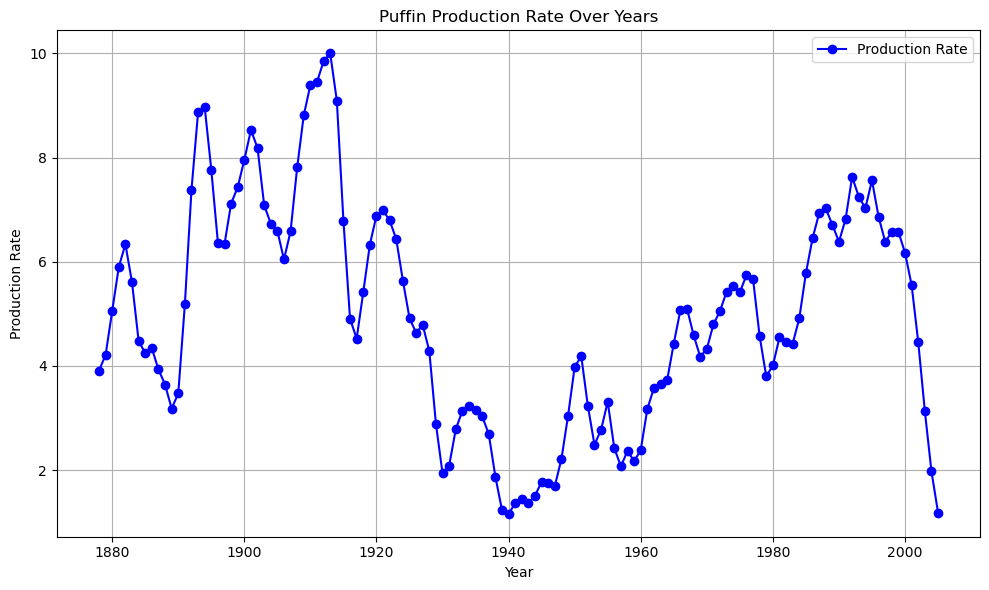

In [19]:

#################### VISUALIZE PUFFIN DATA #################

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data (puffin production rate)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Check the data types
print("Data types in puffins:\n", puffins.dtypes)

# Visualize the puffin production rate over the years
plt.figure(figsize=(10, 6))
plt.plot(puffins['time'], puffins['production_rate'], marker='o', linestyle='-', color='blue', label='Production Rate')
plt.title("Puffin Production Rate Over Years")
plt.xlabel("Year")
plt.ylabel("Production Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

We can observe that the population rate fluctuates over the years. According to several scientific articles, including "Centennial relationships between ocean temperature and Atlantic puffin production reveal shifting decennial trends," there is a connection between climate change, sea surface temperature, and puffin populations, as puffins are marine birds.

## Let's visualize the link between puffin and sea surface temperature

In [ ]:

########################## VISUALIZING PUFFIN AND TEMPERATURE ###################
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load NetCDF data (temperatures)
nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
data = xr.open_dataset(nc_file)

# Calculate the annual mean of temperatures
temperature = data['tos'].resample(time="1Y").mean().to_dataframe()
temperature.reset_index(inplace=True)

# Convert 'time' to full years
temperature['time'] = temperature['time'].astype(str)  # Convert cftime to string
temperature['time'] = pd.to_datetime(temperature['time'])  # Convert to datetime
temperature['time'] = temperature['time'].dt.year.astype('int64')  # Extract year as integer

# Load CSV data (puffin production rates)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge data on the 'time' column (inner join)
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], on="time", how="inner")

# Visualize temperature and production rate over the years
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on Y-axis 1
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Surface Temperature (°C)", color="tab:blue")
ax1.plot(merged_data['time'], merged_data['tos'], color="tab:blue", label="Temperature")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add a second Y-axis for the puffin production rate
ax2 = ax1.twinx()  # Share the X-axis
ax2.set_ylabel("Puffin Production Rate", color="tab:green")
ax2.plot(merged_data['time'], merged_data['production_rate'], color="tab:green", label="Puffin Production", linestyle="--")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Add a title and customize the plot
fig.suptitle("Temperature and Puffin Production Rate Over the Years", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()


# Display the plot
plt.show()

We can see that when the sea surface temperature is rising, the puffin population rate is dropping.

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


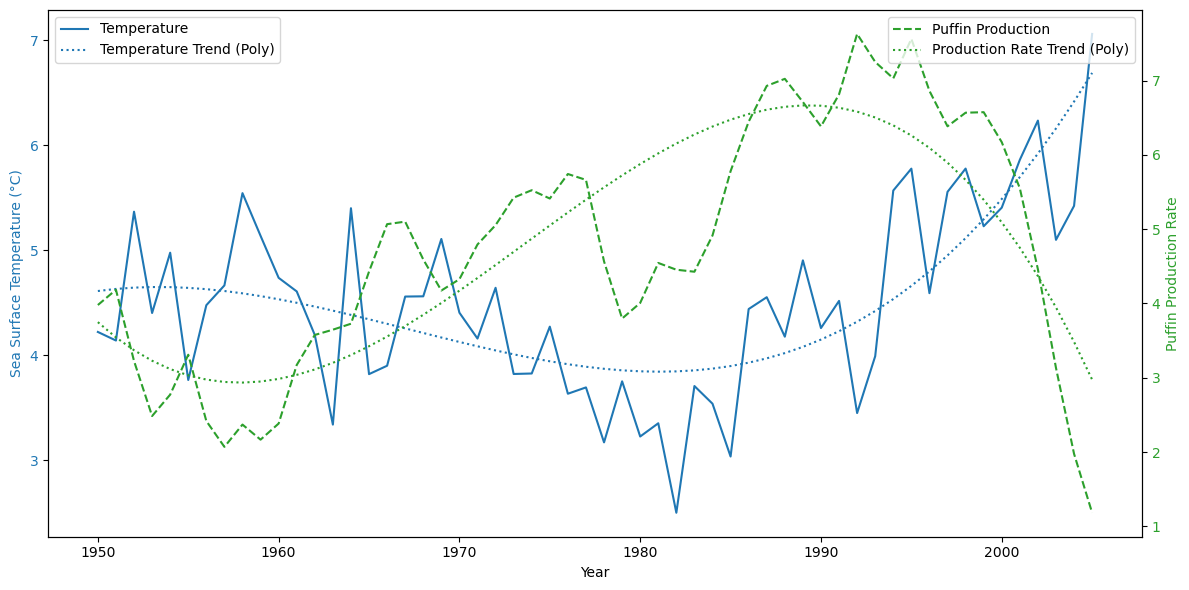

In [26]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Load NetCDF data (temperatures)
nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
data = xr.open_dataset(nc_file)

# Calculate the annual mean of temperatures
temperature = data['tos'].resample(time="1Y").mean().to_dataframe()
temperature.reset_index(inplace=True)

# Convert 'time' to full years
temperature['time'] = temperature['time'].astype(str)  # Convert cftime to string
temperature['time'] = pd.to_datetime(temperature['time'])  # Convert to datetime
temperature['time'] = temperature['time'].dt.year.astype('int64')  # Extract year as integer

# Load CSV data (puffin production rates)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge data on the 'time' column (inner join)
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], on="time", how="inner")

# Clean data: remove rows with missing values (NaNs)
cleaned_data = merged_data.dropna()

# Visualize temperature and production rate over the years
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot temperature on Y-axis 1
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Surface Temperature (°C)", color="tab:blue")
ax1.plot(cleaned_data['time'], cleaned_data['tos'], color="tab:blue", label="Temperature")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add a second Y-axis for the puffin production rate
ax2 = ax1.twinx()  # Share the X-axis
ax2.set_ylabel("Puffin Production Rate", color="tab:green")
ax2.plot(cleaned_data['time'], cleaned_data['production_rate'], color="tab:green", label="Puffin Production", linestyle="--")
ax2.tick_params(axis="y", labelcolor="tab:green")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Polynomial regression for the temperature
poly_temp = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
temp_years = cleaned_data['time'].values.reshape(-1, 1)
poly_temp.fit(temp_years, cleaned_data['tos'])
temp_poly_trend = poly_temp.predict(temp_years)
ax1.plot(cleaned_data['time'], temp_poly_trend, color="tab:blue", linestyle=":", label="Temperature Trend (Poly)")

# Polynomial regression for the puffin production
poly_prod = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
poly_prod.fit(temp_years, cleaned_data['production_rate'])
prod_poly_trend = poly_prod.predict(temp_years)
ax2.plot(cleaned_data['time'], prod_poly_trend, color="tab:green", linestyle=":", label="Production Rate Trend (Poly)")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Adjust layout
fig.tight_layout()

# Display the plot
plt.show()


## Let's try to predict the puffin population in the next years in Vestmann Islands according to sea surface temperature

As the article mentions that the relationship between puffin population and sea surface temperature is not linear, we will initially use a random forest model to predict the puffin population in the coming years on the Vestmann Islands.

### Cleaning the data

Before running the model, it is important to clean the data we have. First, we have annual data for the puffin population rate and daily data for sea surface temperature. The time ranges also differ. Therefore, it is necessary to aggregate the sea surface temperature data to an annual format and clean any empty lines before running the model.

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Values before converting 'time' in temperature:  0    1950-12-30 00:00:00
1    1951-12-30 00:00:00
2    1952-12-30 00:00:00
3    1953-12-30 00:00:00
4    1954-12-30 00:00:00
Name: time, dtype: object
Values after converting 'time' in temperature:  0    1950
1    1951
2    1952
3    1953
4    1954
Name: time, dtype: int64
Data types of temperature:
 time           int64
j              int32
i              int32
latitude     float32
longitude    float32
tos          float32
dtype: object
Data types of puffins:
 time                 int64
production_rate    float64
LCI                float64
UCI                float64
SST                float64
AMO                float64
NAO                float64
AO                 float64
SPG                float64
ENSO               float64
Harv               float64
Src                 object
Days               float64
dtype: object
Available years in temperature: [1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1

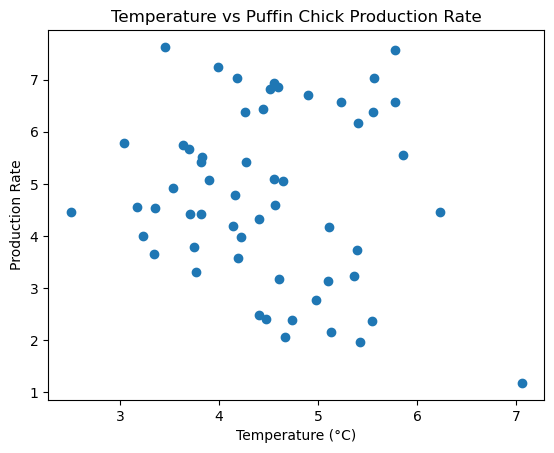

In [1]:
################### cleaning the data ##############

import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the NetCDF data (temperatures)
nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
data = xr.open_dataset(nc_file)

# Annual mean temperatures
temperature = data['tos'].resample(time="1Y").mean().to_dataframe()
temperature.reset_index(inplace=True)

# Check the values in the 'time' column before conversion
print("Values before converting 'time' in temperature: ", temperature['time'].head())

# Convert 'time' from cftime to string
temperature['time'] = temperature['time'].astype(str)

# Convert to datetime after conversion to string
temperature['time'] = pd.to_datetime(temperature['time'])

# Extract the year and convert it to int64
temperature['time'] = temperature['time'].dt.year.astype('int64')

# Check the values after conversion
print("Values after converting 'time' in temperature: ", temperature['time'].head())

# Load the puffin data (chick production rate)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Check the data types
print("Data types of temperature:\n", temperature.dtypes)
print("Data types of puffins:\n", puffins.dtypes)

# Check if the years in 'temperature' and 'puffins' match
print("Available years in temperature:", temperature['time'].unique())
print("Available years in puffins:", puffins['time'].unique())

# Merge the data by year (column 'time')
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], on="time", how='inner')

# Check the result of the merge
print("Data after merge:\n", merged_data.head())

# Check for missing rows
print(f"Number of missing rows after merge: {merged_data.isnull().sum().sum()}")

# Visualize the data
plt.scatter(merged_data['tos'], merged_data['production_rate'])
plt.title("Temperature vs Puffin Chick Production Rate")
plt.xlabel("Temperature (°C)")
plt.ylabel("Production Rate")
plt.show()

In [3]:
# Prepare the data for the model
X = merged_data[['tos']]  # Temperature
y = merged_data['production_rate']  # Production rate

# Check for missing values in y
print("Missing values in y:", y.isnull().sum())

# Remove rows where y is missing, and remove corresponding rows in X
merged_data_clean = merged_data.dropna(subset=['production_rate', 'tos'])

# Check that there are no more NaN values in y after cleaning
X_clean = merged_data_clean[['tos']]
y_clean = merged_data_clean['production_rate']

print("Missing values after cleaning in y_clean:", y_clean.isnull().sum())

Missing values in y: 9
Missing values after cleaning in y_clean: 0


### Random Forest model

Missing values after split in y_train: 0
Missing values after split in y_test: 0


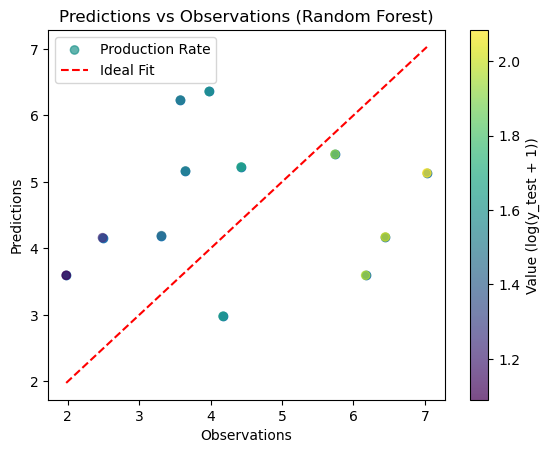

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Verify that there are no more NaN values after the split
print("Missing values after split in y_train:", y_train.isnull().sum())
print("Missing values after split in y_test:", y_test.isnull().sum())

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Visualize the performance
plt.scatter(y_test, y_pred)
plt.title("Predictions vs Observations (Random Forest)")
plt.xlabel("Observations")
plt.ylabel("Predictions")

# Create colors based on 'y_test' or another variable, here we use 'y_test' for the color
colors = np.log1p(y_test)  # Example of scaling the colors with log(y_test + 1)

# Visualize the predictions
scatter = plt.scatter(y_test, y_pred, c=colors, cmap='viridis', label='Production Rate', alpha=0.7)

# Add title and labels
plt.title("Predictions vs Observations (Random Forest)")
plt.xlabel("Observations")
plt.ylabel("Predictions")

# Add color bar for the legend
cbar = plt.colorbar(scatter)  # Associate the color bar with the 'scatter' object
cbar.set_label('Value (log(y_test + 1))')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit") #Add a fit line to determine how the model is working

plt.legend()

plt.show()

### Random forest model and predictions

Scenario 1 (Temperature = 5.66°C): Predicted Production Rate = 5.48
Scenario 2 (Temperature = 6.66°C): Predicted Production Rate = 2.16
Scenario 3 (Temperature = 7.66°C): Predicted Production Rate = 2.16


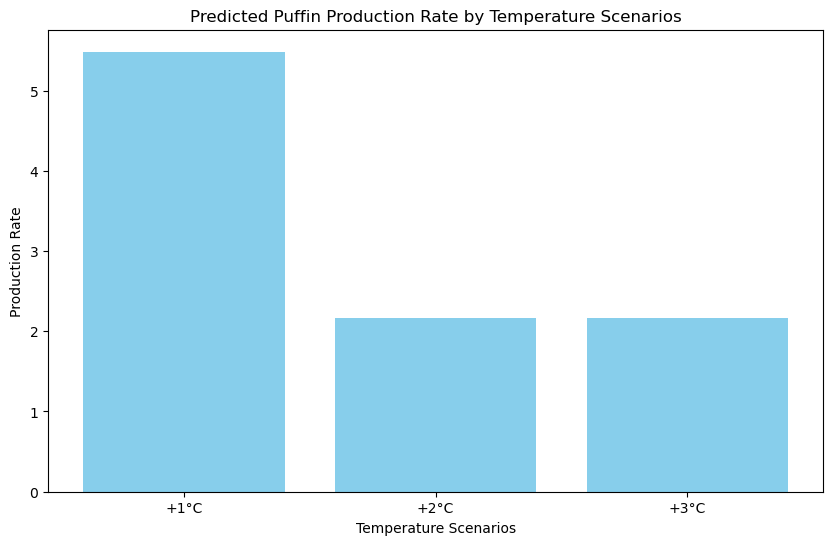

In [8]:

# Temperature scenarios
future_scenarios = pd.DataFrame({
    'tos': [X['tos'].mean() + 1, X['tos'].mean() + 2, X['tos'].mean() + 3]
})

# Predictions for the scenarios
future_predictions = rf_model.predict(future_scenarios)

# Display predictions
for i, scenario in enumerate(future_scenarios['tos']):
    print(f"Scenario {i+1} (Temperature = {scenario:.2f}°C): Predicted Production Rate = {future_predictions[i]:.2f}")

# Visualize predictions for the scenarios
plt.figure(figsize=(10, 6))
plt.bar(['+1°C', '+2°C', '+3°C'], future_predictions, color='skyblue')
plt.title("Predicted Puffin Production Rate by Temperature Scenarios")
plt.ylabel("Production Rate")
plt.xlabel("Temperature Scenarios")
plt.show()

### Evaluating the performance of the model

In [10]:
# Evaluate performance

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 3.23
R² Score: -0.37


### Analize of the first results

The results show that the Random Forest model is not performing well:

- **High MSE**: A high Mean Squared Error value indicates that the model is making significant errors in its predictions.  
- **Negative R²**: This means that the model performs worse than simply predicting the mean of the observations (in other words, it is useless in its current state).


Cross-validated R² scores: [-14.89782383  -7.49020415  -0.87720679 -11.85327373  -0.44471821]
Average R²: -7.112645342984341


Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


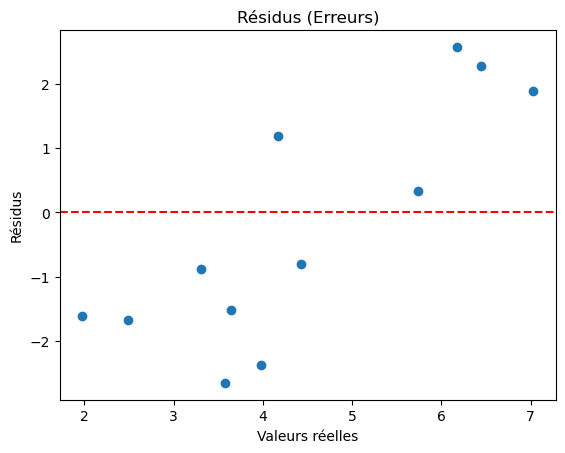

In [6]:

#cross-validation

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X_clean, y_clean, cv=5, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Average R²:", scores.mean())

#Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)


residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus (Erreurs)")
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.show()


Let's do the same but let's try to predict puffin population according to the different copernicus scenarios.

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


Future temperature data:
    time    j    i   latitude  longitude       tos
0  2015  286  297  63.334877  20.103542  6.036432
1  2016  286  297  63.334877  20.103542  5.873781
2  2017  286  297  63.334877  20.103542  6.262249
3  2018  286  297  63.334877  20.103542  6.185034
4  2019  286  297  63.334877  20.103542  6.548025
Scenario 6.036432266235352°C: Predicted Production Rate = 5.41
Scenario 5.873780727386475°C: Predicted Production Rate = 5.89
Scenario 6.262248992919922°C: Predicted Production Rate = 4.92
Scenario 6.185033798217773°C: Predicted Production Rate = 4.92
Scenario 6.548024654388428°C: Predicted Production Rate = 3.77
Scenario 5.76177453994751°C: Predicted Production Rate = 7.04
Scenario 7.068575382232666°C: Predicted Production Rate = 2.16
Scenario 6.9985127449035645°C: Predicted Production Rate = 2.16
Scenario 5.372547149658203°C: Predicted Production Rate = 3.41
Scenario 6.497040271759033°C: Predicted Production Rate = 3.77
Scenario 7.30549955368042°C: Predicted Produ

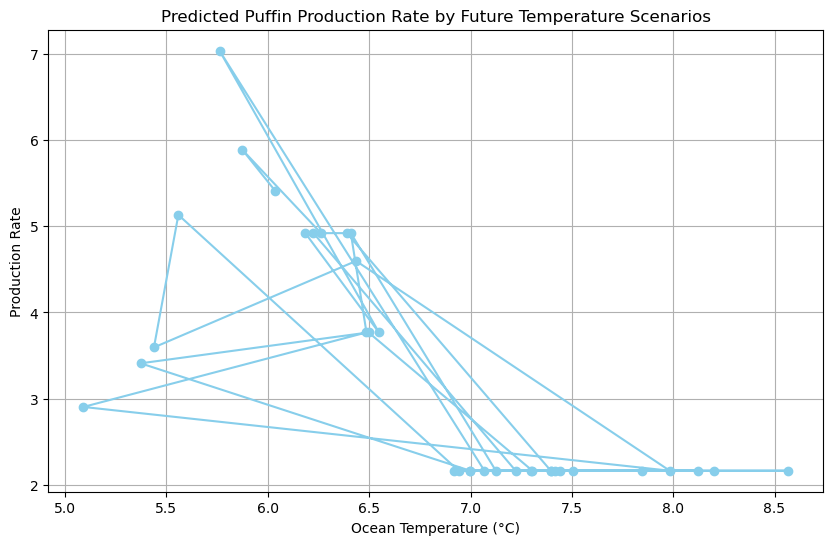

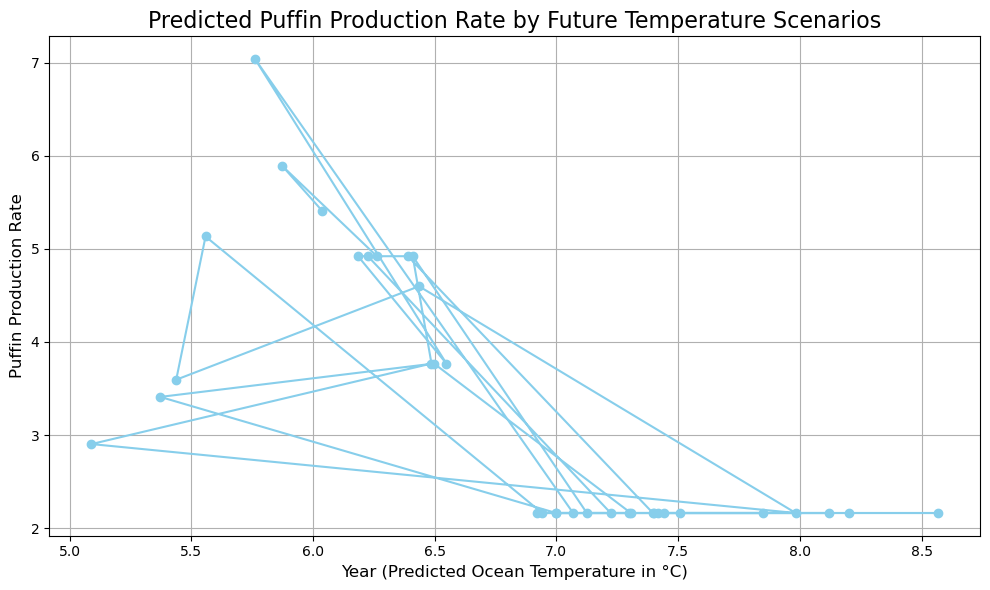

In [46]:
# Load future temperature data (here, assuming a CSV or NetCDF file with forecasts)
# If you have a NetCDF file with future temperatures, you can load it the same way as the past data.
future_nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc"
future_data = xr.open_dataset(future_nc_file)

# Annual mean temperatures for the future (for example, for 2049)
future_temperature = future_data['tos'].resample(time="1Y").mean().to_dataframe()
future_temperature.reset_index(inplace=True)

# Convert 'time' from cftime to string
future_temperature['time'] = future_temperature['time'].astype(str)

# Convert to datetime after conversion to string
future_temperature['time'] = pd.to_datetime(future_temperature['time'])

# Extract the year and convert it to int64
future_temperature['time'] = future_temperature['time'].dt.year.astype('int64')

# Display future data to verify
print("Future temperature data:\n", future_temperature.head())

# Prepare future data (using the average temperature for prediction)
future_scenarios = pd.DataFrame({
    'tos': future_temperature['tos']  # Use future temperatures for prediction
})

# Predictions for future scenarios
future_predictions = rf_model.predict(future_scenarios)

# Display predictions for each future year
for i, scenario in enumerate(future_scenarios['tos']):
    print(f"Scenario {future_scenarios['tos'].iloc[i]}°C: Predicted Production Rate = {future_predictions[i]:.2f}")

# Visualize predictions for future scenarios
plt.figure(figsize=(10, 6))
plt.plot(future_scenarios['tos'], future_predictions, marker='o', color='skyblue')
plt.title("Predicted Puffin Production Rate by Future Temperature Scenarios")
plt.xlabel("Ocean Temperature (°C)")
plt.ylabel("Production Rate")
plt.grid(True)
plt.show()

# Create a visualization with time on the x-axis and predicted production rate on the y-axis
plt.figure(figsize=(10, 6))
plt.plot(future_scenarios['tos'], future_predictions, marker='o', linestyle='-', color='skyblue')

# Add title, axis labels, and formatting options
plt.title("Predicted Puffin Production Rate by Future Temperature Scenarios", fontsize=16)
plt.xlabel("Year (Predicted Ocean Temperature in °C)", fontsize=12)
plt.ylabel("Puffin Production Rate", fontsize=12)
plt.grid(True)

# Display the figure
plt.tight_layout()


# Display the figure
plt.show()

# Import necessary libraries
import matplotlib.pyplot as plt

# Assuming you have future temperature data for the years 2023-2049 in `future_scenarios`
# and you have already trained your RandomForest model (rf_model) to make predictions.

# Suppose 'temperature' contains a series of temperatures for the years 2023 to 2049 (for example)
# And you want to predict the production rate for each year based on ocean temperatures

# Example: creating a DataFrame with future temperatures for the years 2023-2049
future_years = range(2023, 2050)  # Future years
future_temperatures = X['tos'].mean() + np.arange(1, len(future_years) + 1)  # Future temperature scenarios

# Create a DataFrame with these temperature scenarios for each future year
future_scenarios = pd.DataFrame({
    'time': future_years,
    'tos': future_temperatures
})

# Predictions for these future years
future_predictions = rf_model.predict(future_scenarios[['tos']])

#


### Sample through a "puffin year" (September to August)

We try another sample of data with a year that follow the puffin breading season from september to august.

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF data (temperatures)
nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
data = xr.open_dataset(nc_file)

# Check the available variables in the dataset
print("Available variables in the dataset:", data.keys())

#############################@ L'ERREUR VIENT D'ICI #####################################

# Ensure that 'time' is already in datetime format (xarray handles it well)
data['time'] = pd.to_datetime(data['time'].values)

##########################################################################################

# Shift months before September to belong to the previous year
data['time'] = data['time'].where(data['time'].dt.month >= 9, data['time'] - pd.Timedelta(days=365))

# Create a new 'season_year' based on adjusted time
data['season_year'] = data['time'].dt.year

# Calculate the annual mean temperatures from September to August (group by season_year)
temperature = data['tos'].groupby('season_year').mean(dim=['j', 'i']).to_dataframe()

# Reset the index for the dataframe
temperature.reset_index(inplace=True)

# Check the values in the 'season_year' column before conversion
print("Values before converting 'season_year' in temperature: ", temperature['season_year'].head())

# Convert 'season_year' from integer to string and back to datetime
temperature['season_year'] = temperature['season_year'].astype(str)
temperature['season_year'] = pd.to_datetime(temperature['season_year'])
temperature['season_year'] = temperature['season_year'].dt.year.astype('int64')

# Check the values after conversion
print("Values after converting 'season_year' in temperature: ", temperature['season_year'].head())

# Load the puffin data (chick production rate)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")

# Rename the 'Year' column to 'time' to match the temperature column
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Check the data types
print("Data types of temperature:\n", temperature.dtypes)
print("Data types of puffins:\n", puffins.dtypes)

# Check if the years in 'temperature' and 'puffins' match
print("Available years in temperature:", temperature['season_year'].unique())
print("Available years in puffins:", puffins['time'].unique())

# Merge the data by year (column 'time')
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], left_on="season_year", right_on="time", how='inner')

# Check the result of the merge
print("Data after merge:\n", merged_data.head())

# Check for missing rows
print(f"Number of missing rows after merge: {merged_data.isnull().sum().sum()}")

# Visualize the data
plt.scatter(merged_data['tos'], merged_data['production_rate'])
plt.title("Temperature vs Puffin Chick Production Rate")
plt.xlabel("Temperature (°C)")
plt.ylabel("Production Rate")
plt.show()

Available variables in the dataset: KeysView(<xarray.Dataset> Size: 22kB
Dimensions:             (time: 780, bnds: 2, j: 1, i: 1, vertices: 4)
Coordinates:
  * time                (time) object 6kB 1950-01-16 00:00:00 ... 2014-12-16 ...
  * j                   (j) int32 4B 286
  * i                   (i) int32 4B 297
    latitude            (j, i) float32 4B ...
    longitude           (j, i) float32 4B ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 12kB ...
    vertices_latitude   (j, i, vertices) float32 16B ...
    vertices_longitude  (j, i, vertices) float32 16B ...
    tos                 (time, j, i) float32 3kB ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T14:05:38Z
    ...                     ...
    title:                 

TypeError: <class 'cftime._cftime.Datetime360Day'> is not convertible to datetime, at position 0

<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


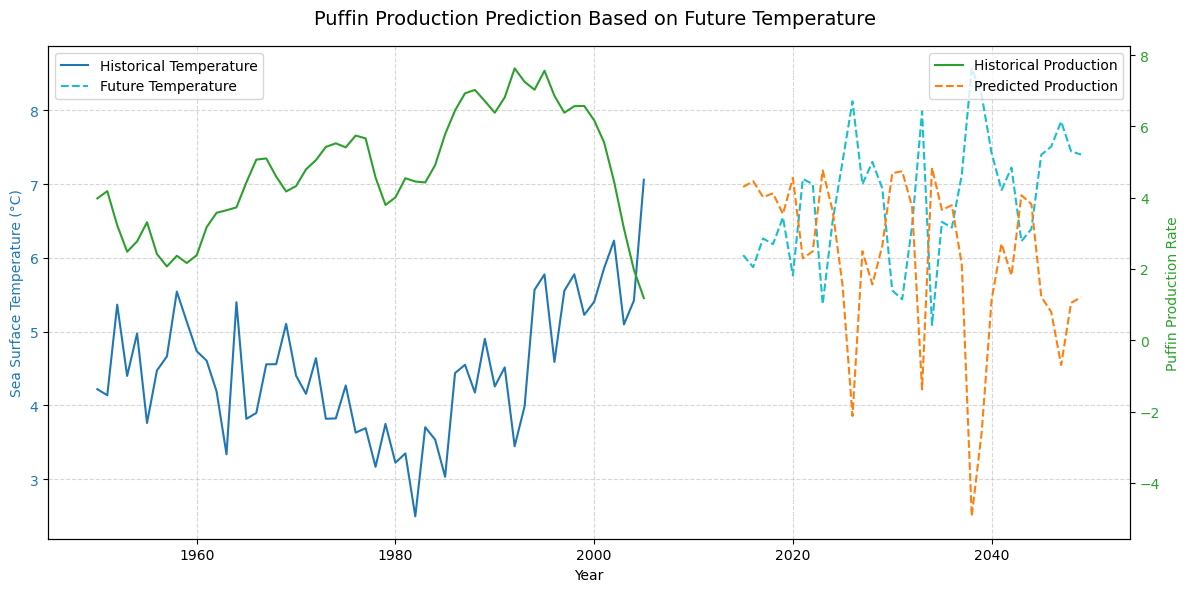

Future Temperature and Predicted Production:
   time       tos  predicted_production
0  2015  6.036432              4.301196
1  2016  5.873781              4.462587
2  2017  6.262249              4.016478
3  2018  6.185034              4.122225
4  2019  6.548025              3.542369


In [30]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# ################### Cleaning the Data ####################

# Load NetCDF data (temperatures)
nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500116-20141216.nc"
data = xr.open_dataset(nc_file)

# Annual mean temperatures
temperature = data['tos'].resample(time="1Y").mean().to_dataframe()
temperature.reset_index(inplace=True)

# Convert 'time' to full years (int64)
temperature['time'] = temperature['time'].astype(str)
temperature['time'] = pd.to_datetime(temperature['time'])
temperature['time'] = temperature['time'].dt.year.astype('int64')

# Load puffin data (CSV)
puffins = pd.read_csv("data/local_puffin_files/puffin-data1_Data.csv")
puffins.rename(columns={"Year": "time", "Prod": "production_rate"}, inplace=True)

# Merge temperature and puffin production data
merged_data = pd.merge(temperature, puffins[['time', 'production_rate']], on="time", how='inner')
merged_data = merged_data.dropna()

# ################### Model Training and Prediction ####################

# Fit Polynomial Regression Model on Historical Data
degree = 3  # Polynomial degree
coeffs = np.polyfit(merged_data['tos'], merged_data['production_rate'], degree)
poly_model = Polynomial(coeffs[::-1])  # Polynomial model

# Load Future Temperature Data
future_nc_file = "data/local_cds_files/tos_Omon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_20150116-20491216.nc"
future_data = xr.open_dataset(future_nc_file)

# Calculate annual mean for future temperatures
future_temperature = future_data['tos'].resample(time="1Y").mean().to_dataframe()
future_temperature.reset_index(inplace=True)
future_temperature['time'] = future_temperature['time'].astype(str)
future_temperature['time'] = pd.to_datetime(future_temperature['time'])
future_temperature['time'] = future_temperature['time'].dt.year.astype('int64')

# Predict Puffin Production for Future Temperatures
future_temperature['predicted_production'] = poly_model(future_temperature['tos'])

# ################### Visualization ####################

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot historical data
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Surface Temperature (°C)", color="tab:blue")
ax1.plot(merged_data['time'], merged_data['tos'], color="tab:blue", label="Historical Temperature")
ax1.plot(future_temperature['time'], future_temperature['tos'], color="tab:cyan", linestyle="--", label="Future Temperature")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Add secondary axis for puffin production
ax2 = ax1.twinx()
ax2.set_ylabel("Puffin Production Rate", color="tab:green")
ax2.plot(merged_data['time'], merged_data['production_rate'], color="tab:green", label="Historical Production")
ax2.plot(future_temperature['time'], future_temperature['predicted_production'], color="tab:orange", linestyle="--", label="Predicted Production")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Add title and grid
fig.suptitle("Puffin Production Prediction Based on Future Temperature", fontsize=14)
ax1.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()

# Show plot
plt.show()

# ################### Results ####################

# Display predicted production for the first few years
print("Future Temperature and Predicted Production:")
print(future_temperature[['time', 'tos', 'predicted_production']].head())


Evaluation Metrics on Test Data:
 - MSE (Mean Squared Error): 2.77
 - RMSE (Root Mean Squared Error): 1.66
 - R² (Coefficient of Determination): -0.18


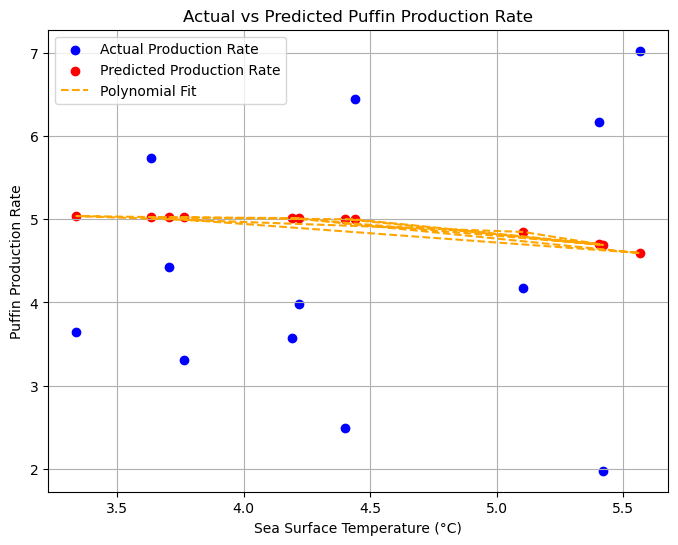

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# ################### Split Data into Training and Test Sets ####################

# Split merged_data into training (80%) and testing (20%) sets
X = merged_data['tos'].values.reshape(-1, 1)  # Temperature values
y = merged_data['production_rate'].values  # Production rates

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ################### Train Polynomial Regression Model ####################

# Fit Polynomial Regression Model on Training Data
degree = 3  # Polynomial degree
coeffs = np.polyfit(X_train.flatten(), y_train, degree)  # Fit on training data
poly_model = Polynomial(coeffs[::-1])  # Reverse coeffs for Polynomial function

# ################### Predict on Test Data ####################

# Predict production rates for the test data
y_pred = poly_model(X_test.flatten())

# ################### Evaluate Model Performance ####################

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R² (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

# Print Evaluation Metrics
print(f"Evaluation Metrics on Test Data:")
print(f" - MSE (Mean Squared Error): {mse:.2f}")
print(f" - RMSE (Root Mean Squared Error): {rmse:.2f}")
print(f" - R² (Coefficient of Determination): {r2:.2f}")

# ################### Visualize Predicted vs Actual ####################

# Plot actual vs predicted production rates on test data
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color="blue", label="Actual Production Rate")
plt.scatter(X_test, y_pred, color="red", label="Predicted Production Rate")
plt.plot(X_test, y_pred, color="orange", linestyle="--", label="Polynomial Fit")
plt.xlabel("Sea Surface Temperature (°C)")
plt.ylabel("Puffin Production Rate")
plt.title("Actual vs Predicted Puffin Production Rate")
plt.legend()
plt.grid(True)
plt.show()
